# 🔥포스🔥

### 위 게시글을 시리즈물📖입니다.  
**[1편. OpenCV의 기초, Numpy와 Matplotlib](https://dacon.io/codeshare/4768?page=1&dtype=recent)**<br>
**[2편. OpenCV 기초(이미지 입출력, 그리기, 창 관리, 이벤트 처리 등)](https://dacon.io/codeshare/4837?page=1&dtype=recent)**<br>
**[3편. 이미지 프로세싱(컬러 스페이스, 스레시홀딩, 이미지 연산, 히스토그램)](https://dacon.io/codeshare/4858?page=1&dtype=recent)**<br>
**[4편. OpenCV 기하학적 변환](https://dacon.io/codeshare/4875?page=1&dtype=recent)**<br>
**[5편. OpenCV 영상필터](https://dacon.io/codeshare/4898?page=1&dtype=recent)**<br>
**[프로젝트1편. Multi-Hand Gesture Recognition(1)](https://dacon.io/codeshare/4956?page=1&dtype=recent)**<br>
**[프로젝트2편. Multi-Hand Gesture Recognition(2)](https://dacon.io/codeshare/5006?page=1&dtype=recent)**<br>
**[6편. OpenCV 영상분할](https://dacon.io/codeshare/5072?page=1&dtype=recent&fType=)**<br>
**[7편. OpenCV 영상매칭과 추척](https://dacon.io/codeshare/5106)**<br>
**[8편. OpenCV과 머신러닝편(1)(K-means, K-NN, SVM)](https://dacon.io/codeshare/5146?page=1&dtype=recent&fType=)**    
**[8편.OpenCV과 머신러닝편(2)(HOG, BOW, 케스케이드 분류기)](https://dacon.io/codeshare/5179)**



<br>
<br>

**프로젝트 게시글**<br>
**[프로젝트 1편. Segmentation Modeling(1) (U-Net, OpenCV 적용)](https://dacon.io/codeshare/5185)**

* 안녕하세요 :) 데이크루 2기 *포스팀*입니다!
* 저희 마지막 프로젝트 게시글에 들어와주셔서 감사합니다!
* 앞으로도 포스팀의 행방 지켜봐주세요!

주제는!!! 동일하게,

✨
## **Segmentation Modeling(분할 모델링)**
✨


이제 모델만 달라진...그런..

## 목차

### 1) ResU-NET 이란?
### 2) 데이터 설명
### 3) Code
#### 3-1) Data Augmentation 적용 x
#### 3-2) 논문 Data Augmentation 적용 o
#### 3-3) OpenCV 적용
### 4) 결론

# 그럼 시작합니다 ~:)



### 1) **ResU-Net** : Road Extraction by Deep Residual U-Net

기존 UNet에서 Encoder 및 Decoder 부분의 block마다 residual unit with identity mapping을 적용 하였습니다.

![image](https://user-images.githubusercontent.com/82289435/174439994-c197b3e4-a38f-4e6e-bdfb-cfc3c1b69fc2.png)

[reference](https://www.researchgate.net/figure/Qualitative-evaluation-of-the-segmentation-results-produced-by-the-three-compared-methods_fig3_335802605)


제안 목적
- 의료 이미지의 낮은 수준의 특징 분포를 인코딩하기 위해 Residual Unit을 도입하는 것을 제안하였습니다.

- 정보의 손실을 최소화하며 low-level feature를 인식할 수 있도록 합니다.

![그림1](https://user-images.githubusercontent.com/82289435/174447505-0643dbcf-2dbe-4dc8-b6db-3a256c3226c8.png)


### U-Net with Residual unit

Encoder block과 decoder block를 내의하며 각 layer를 그림에서 보이는 residual unit으로 연결합니다. Image를 통과시킬 때, 감소 관점에서 shape-aware information를 유지할 수 있는 장점이 있고, 계산 cost 측면에서 이점이 있습니다.  

shape-aware information은 fully-convolutional neural network 관점에서,
multi-layer를 쌓아감에 있어 초기 layer의 filter는 이미지의 shape, edge와 같은
location feature를 추출하며, final layer의 filter는 이미지의 형태적 정보보다는
semantic feature를 추출하는 경향이 있습니다. 그러므로 layer를 쌓을 때, residual
unit (identity mapping)으로 연결하여 앞 단락에서 설명한 shape-aware information을
final layer에서도 최대한 유지시키고자 이 모델을 제안하였습니다.

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, padding):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
        )
        """ Residual block과 channel size를 맞추기 위한 conv operation """
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1),
        ) 
    
    def forward(self, inputs):
        r = self.conv_block(inputs)
        s = self.shortcut(inputs)
        
        skip = r + s
        return skip

class ResUNet(nn.Module):
    def __init__(self, num_classes):
        super(ResUNet, self).__init__()
        self.num_classes = num_classes
        
        """ Encoder input layer """
        self.contl_1 = self.input_block(in_channels=3, out_channels=64)
        self.contl_2 = self.input_skip(in_channels=3, out_channels=64)
        
        """ Residual encoder block """
        self.resdl_1 = ResidualBlock(64, 128, 2, 1)
        self.resdl_2 = ResidualBlock(128, 256, 2, 1)
        #self.resdl_3 = ResidualBlock(256, 512, 2, 1)
        
        """ Encoder decoder skip connection """
        self.middle = ResidualBlock(256, 512, 2, 1)
        
        """ Decoder block """
        self.expnl_1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, 
                                          kernel_size=2, stride=2, padding=0)
        self.expnl_1_cv = ResidualBlock(256+256, 256, 1, 1)
        self.expnl_2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, 
                                          kernel_size=2, stride=2, padding=0)
        self.expnl_2_cv = ResidualBlock(128+128, 128, 1, 1)
        self.expnl_3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, 
                                          kernel_size=2, stride=2, padding=0)
        self.expnl_3_cv = ResidualBlock(64+64, 64, 1, 1)
        # self.expnl_4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, 
        #                                   kernel_size=2, stride=2, padding=0)
        # self.expnl_4_cv = ResidualBlock(128+64, 64, 1, 1)
        
        self.output = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1),
          nn.Sigmoid(),
        )
        
    def input_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    )
        return block
    
    def input_skip(self, in_channels, out_channels):
        skip = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1)
        return skip                         
    
    def forward(self, X):
        contl_1_out = self.contl_1(X) # 64
        contl_2_out = self.contl_2(X) # 64
        input_out = contl_1_out + contl_2_out
        
        resdl_1_out = self.resdl_1(input_out) # 128
        resdl_2_out = self.resdl_2(resdl_1_out) # 256
        #resdl_3_out = self.resdl_3(resdl_2_out) # 512
        
        middle_out = self.middle(resdl_2_out) # 512
        
        expnl_1_out = self.expnl_1(middle_out)
        expnl_1_cv_out = self.expnl_1_cv(torch.cat((expnl_1_out, resdl_2_out), dim=1)) # 512
        expnl_2_out = self.expnl_2(expnl_1_cv_out) # 256
        expnl_2_cv_out = self.expnl_2_cv(torch.cat((expnl_2_out, resdl_1_out), dim=1))
        expnl_3_out = self.expnl_3(expnl_2_cv_out)
        expnl_3_cv_out = self.expnl_3_cv(torch.cat((expnl_3_out, contl_1_out), dim=1))
        # expnl_4_out = self.expnl_4(expnl_3_cv_out)
        # expnl_4_cv_out = self.expnl_4_cv(torch.cat((expnl_4_out, input_out), dim=1))
        
        out = self.output(expnl_3_cv_out)
        return out

### 사용한 판단 척도

위 게시글에서 판단 척도로는 loss값과 IoU값이 있습니다. IoU값의 식은 **(두 이미지의 교집합)/(두 이미지의 합집합)** 으로 나타낼 수 있습니다.

아래는 구현한 식 입니다.

In [ ]:
def iou(pred, target, n_classes = 2):
    
    iou = []
    pred = pred.view(-1)
    target = target.view(-1)

    # Ignore IoU for background class ("0")
    for cls in range(1, n_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds[target_inds]).long().sum().data.cpu().item()
        union = pred_inds.long().sum().data.cpu().item() + target_inds.long().sum().data.cpu().item() - intersection

        if union == 0:
            iou.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            iou.append(float(intersection) / float(max(union, 1)))

    return sum(iou)

In [ ]:
def iou_metric(y_pred, y_true, n_classes = 2):
    miou = []
    for i in np.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > i)
        iou_init = iou(y_pred_, y_true, n_classes = n_classes)
        miou.append(iou_init)
    
    return sum(miou)/len(miou)

### 2) 데이터 설명

이전 게시글에서 했던 데이터와 동일한 데이터를 사용하였습니다. 데이터 출처는 https://www.kaggle.com/competitions/data-science-bowl-2018 입니다.

- /stage1_train/* : train 세트 이미지 (images and annotated masks)  
- /stage1_test/* : test 이미지 (images only, you are predicting the masks)

### 3) Code

구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


패키지 불러오기

In [ ]:
import os
import random
from sklearn.model_selection import train_test_split
import torchvision.transforms.functional as TF

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

import numpy as np
import matplotlib.pyplot as plt

시드 고정

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

gpu 설정

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

필요한 파라미터 설정

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
width_out = 128
height_out = 128

In [1]:
#%cd (자신의 경로)

데이터 불러오기

- 이전 게시글에서 만들었던 numpy array를 이용해서 바로 진행하겠습니다! 따라서 저번에 만들었던 npy파일을 불러옵니다.

In [ ]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

### 1) **Data Augmentation 없이 학습**

- 첫번째로 별도의 과정 없이 기본 이미지만을 가지고 학습을 시키고 결론을 내어보겠습니다! 

custom dataset인 ResUNETDataset class 정의

In [ ]:
class ResUNetDataset(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        # image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        # mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        # angle = random.uniform(-10, 10)
        # width, height = image.size
        # max_dx = 0.1 * width
        # max_dy = 0.1 * height
        # translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        # scale = random.uniform(0.8, 1.2)
        # shear = random.uniform(-0.5, 0.5)
        # image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        # mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        # image = TF.center_crop(image, (128, 128))
        # mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        return image, mask

tensor로 변환된 데이터를 이용한 DataLoader 생성

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [ ]:
train_dataset = ResUNetDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

ResU-NET 정의

In [ ]:
model = ResUNet(num_classes=1).to(device)
# print(model)

parameter 정의

In [ ]:
epochs=25
alpha=5
batch_size = 16
criterion=nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Training

In [ ]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(image.float())

        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))
    
    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader))

Epoch  1  Training Loss:  tensor(0.5663, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.2588, device='cuda:0')
Training IoU:  0.2534807745335792 Validation IoU:  0.17958342510291758
Epoch  2  Training Loss:  tensor(0.2572, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3690, device='cuda:0')
Training IoU:  0.4122603115863447 Validation IoU:  0.33925377765194425
Epoch  3  Training Loss:  tensor(0.1954, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1203, device='cuda:0')
Training IoU:  0.47673196595057693 Validation IoU:  0.6160796894708567
Epoch  4  Training Loss:  tensor(0.1255, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1222, device='cuda:0')
Training IoU:  0.6095992899551864 Validation IoU:  0.7318626615114745
Epoch  5  Training Loss:  tensor(0.0966, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1049, device='cuda:0')
Training IoU:  0.6903095563226703 Validation IoU:  0.7108

Loss, IoU값 시각화

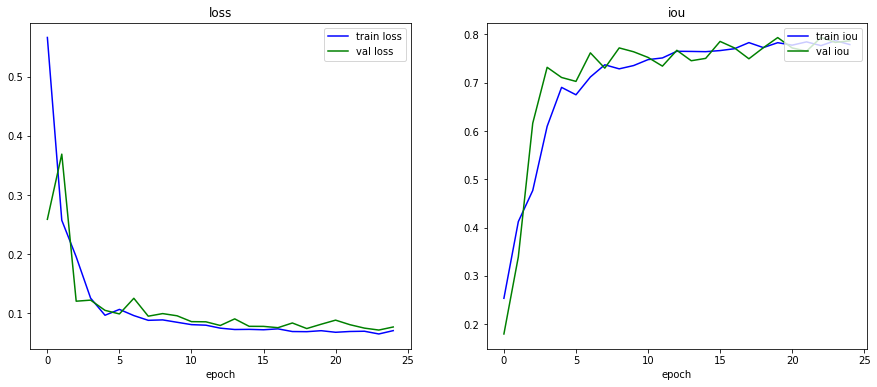

In [ ]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

TEST 실제값, 예측값 시각화

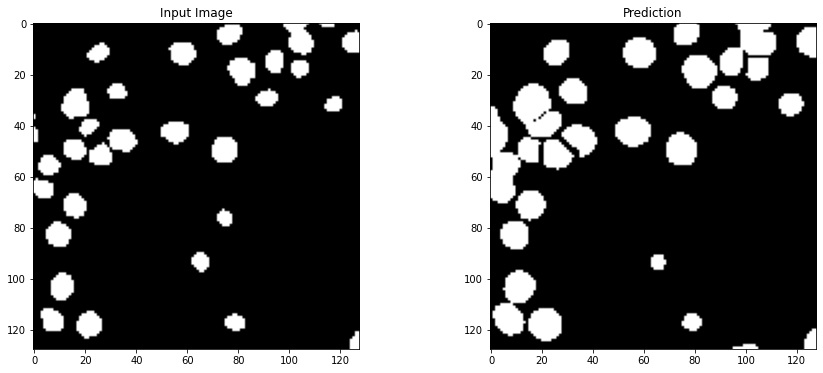

In [ ]:
for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break

- 아무런 Data Augmentation 기법 없이 진행되었을 때는 마지막 epoch에서 Train IoU가 0.78, Validation IoU가 0.78 정도입니다!
- 확실히 이전 게시글보다 잘 잡아낸 느낌이 듭니다. 근데 이번에는 좀 뚱뚱하게 세포를 잡아냈네요!

### **2) 논문 Data Augmentation 기법 적용 후 학습**

- 다음은 앞서 얘기한 논문에서의 전처리 방법을 적용하였습니다.
- Overlap-tile과 center_Crop 그리고 Elastic 변환 방법을 적용하였습니다.

custom dataset인 ResUNetDataset_DAug 정의

In [ ]:
class ResUNetDataset_DAug(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        image = ToPILImage(image_np)
        mask = ToPILImage(mask_np.astype(np.int32))
        
        image = TF.pad(image, padding = 20, padding_mode = 'reflect')
        mask = TF.pad(mask, padding = 20, padding_mode = 'reflect')
        
        angle = random.uniform(-10, 10)
        width, height = image.size
        max_dx = 0.1 * width
        max_dy = 0.1 * height
        translations = (np.round(random.uniform(-max_dx, max_dx)), np.round(random.uniform(-max_dy, max_dy)))
        scale = random.uniform(0.8, 1.2)
        shear = random.uniform(-0.5, 0.5)
        image = TF.affine(image, angle = angle, translate = translations, scale = scale, shear = shear)
        mask = TF.affine(mask, angle = angle, translate = translations, scale = scale, shear = shear)
        
        image = TF.center_crop(image, (128, 128))
        mask = TF.center_crop(mask, (128, 128))
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        return image, mask

tensor로 변환된 데이터를 이용한 DataLoader 생성

In [ ]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [ ]:
train_dataset = ResUNetDataset_DAug(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset_DAug(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

앞서 봤던 U-NET 정의

In [ ]:
model2 = ResUNet(num_classes=1).to(device)

parameter 정의

In [ ]:
epochs=25
alpha=5
batch_size = 16
criterion=nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-3)

Training

In [ ]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model2.train()
    train_loss = 0
    train_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model2(image.float())

        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model2.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model2(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))
    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader))

Epoch  1  Training Loss:  tensor(0.4019, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3729, device='cuda:0')
Training IoU:  0.24021920303238084 Validation IoU:  0.049153536226607265
Epoch  2  Training Loss:  tensor(0.3655, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.2301, device='cuda:0')
Training IoU:  0.32523206998116355 Validation IoU:  0.2935441056295902
Epoch  3  Training Loss:  tensor(0.1646, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1359, device='cuda:0')
Training IoU:  0.49366304437486924 Validation IoU:  0.48667222994811576
Epoch  4  Training Loss:  tensor(0.1230, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1029, device='cuda:0')
Training IoU:  0.5788766155855906 Validation IoU:  0.6591939126697519
Epoch  5  Training Loss:  tensor(0.1104, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1402, device='cuda:0')
Training IoU:  0.6470221346772446 Validation IoU:  0.6

Loss, IoU값 시각화

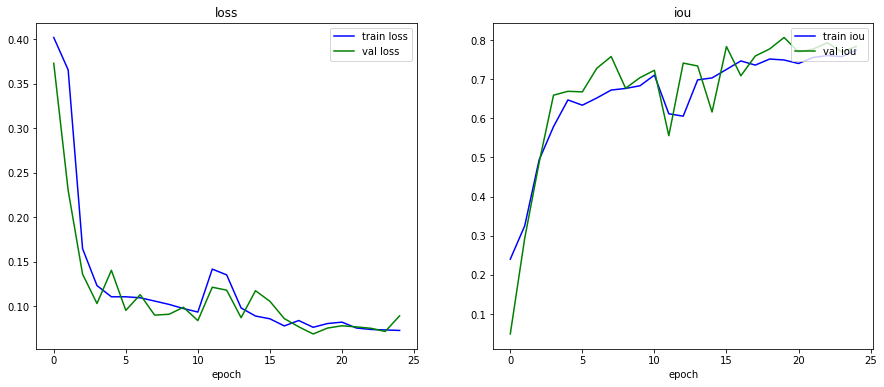

In [ ]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

TEST 실제값, 예측값 시각화

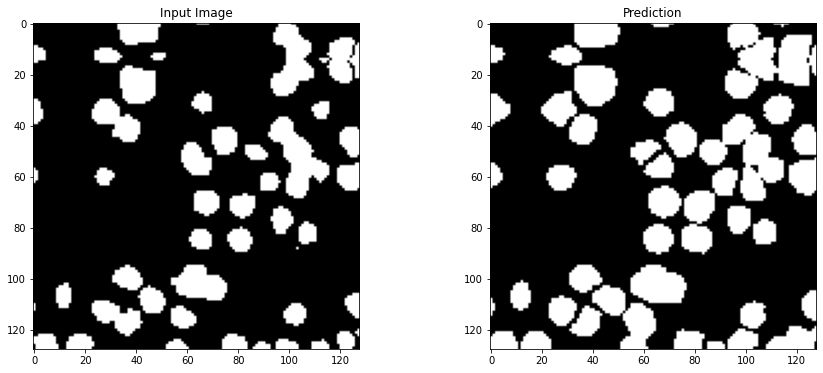

In [ ]:
for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model2(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break

- 논문과 동일한 Data Augmentation 기법을 적용하여 진행되었을 때는 마지막 epoch에서 Train IoU가 0.77, Validation IoU가 0.78 정도로 Augmentation을 적용하지 않았을 때와 비교하였을 때 비슷한 결과값을 얻었습니다. 
- 그래서 얘도 Augmentation을 적용하지 않았을 때와 mask 시각화가 비슷하게 나왔습니다.

### 3) OpenCV Data Augmentation 기법 적용 후 학습
- **Gaussian Blur 적용**
앞선 게시글과 똑같은 기법을 적용하였습니다.

custom dataset UNetDataset_Gaussian class 정의

In [ ]:
class ResUNetDataset_Gaussian(Dataset):
    def __init__(self, images_np, masks_np):
        self.images_np = images_np
        self.masks_np = masks_np
    
    def transform(self, image_np, mask_np):
        ToPILImage = transforms.ToPILImage()
        mask = ToPILImage(mask_np.astype(np.int32))

        kernel_size=(5,5)
        image = cv2.GaussianBlur(image_np, kernel_size,0)
        
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        return image, mask

    def __len__(self):
        return len(self.images_np)
    
    def __getitem__(self, idx):
        image_np = self.images_np[idx]
        mask_np = self.masks_np[idx]
        image, mask = self.transform(image_np, mask_np)
        
        return image, mask

tensor로 변환된 데이터를 이용한 DataLoader 생성

In [ ]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

In [ ]:
train_dataset = ResUNetDataset_Gaussian(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataset = ResUNetDataset_Gaussian(x_val, y_val)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

ResU-NET 정의

In [ ]:
model3 = ResUNet(num_classes=1).to(device)

parameter 정의

In [ ]:
epochs=25
alpha=5
batch_size = 16
criterion=nn.BCELoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-3)

Training

In [ ]:
train_loss_list = []
val_loss_list = []
train_iou_list = []
val_iou_list = []

for epoch in range(epochs):
    model3.train()
    train_loss = 0
    train_iou = 0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model3(image.float())

        loss = criterion(outputs.float(), mask.float())
        train_loss += loss

        train_iou += iou_metric(outputs, mask)
        rev_iou = 16 - iou_metric(outputs, mask)
        loss += alpha * rev_iou

        loss.backward()
        optimizer.step()

    model3.eval()
    with torch.no_grad():
        valid_loss = 0
        valid_iou = 0

        for image_val, mask_val in valid_loader:
            image_val = image_val.to(device)
            mask_val = mask_val.to(device)
            output_val = model3(image_val.float())
            valid_loss += criterion(output_val.float(), mask_val.float())
            valid_iou += iou_metric(output_val, mask_val)

    print("Epoch ", epoch + 1, " Training Loss: ", train_loss/len(train_loader), "Validation Loss: ", valid_loss/len(valid_loader))
    print("Training IoU: ", train_iou/len(train_loader), "Validation IoU: ", valid_iou/len(valid_loader))
    # visualization
    train_loss_list.append(train_loss/len(train_loader))
    val_loss_list.append(valid_loss/len(valid_loader))
    train_iou_list.append(train_iou/len(train_loader))
    val_iou_list.append(valid_iou/len(valid_loader))

Epoch  1  Training Loss:  tensor(0.4475, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.2609, device='cuda:0')
Training IoU:  0.2766857727124951 Validation IoU:  0.20084495411739167
Epoch  2  Training Loss:  tensor(0.3705, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.3449, device='cuda:0')
Training IoU:  0.3871846116581919 Validation IoU:  0.3915643853323522
Epoch  3  Training Loss:  tensor(0.3823, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(3.2437, device='cuda:0')
Training IoU:  0.36611831964456415 Validation IoU:  0.41029925164568215
Epoch  4  Training Loss:  tensor(0.2308, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1581, device='cuda:0')
Training IoU:  0.4462523723203867 Validation IoU:  0.4791105451956286
Epoch  5  Training Loss:  tensor(0.1331, device='cuda:0', grad_fn=<DivBackward0>) Validation Loss:  tensor(0.1418, device='cuda:0')
Training IoU:  0.5647356483637886 Validation IoU:  0.5882

Loss, IoU값 시각화

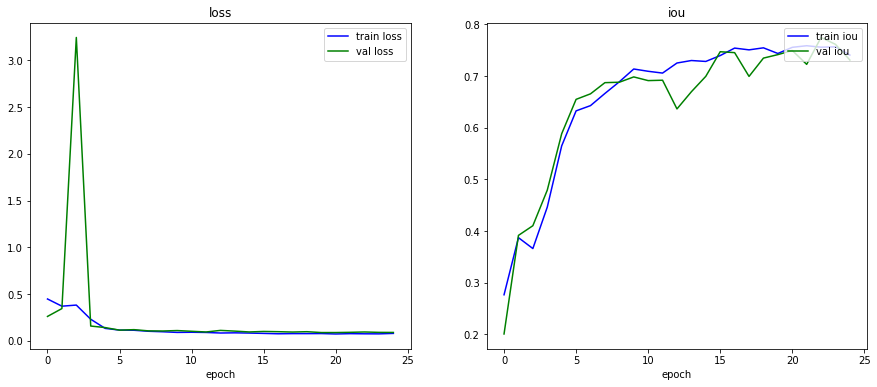

In [ ]:
train_loss_data = [i.detach().cpu().numpy() for i in train_loss_list]
val_loss_data = [i.detach().cpu().numpy() for i in val_loss_list]
# train_iou_data = [i.detach().cpu().numpy() for i in train_iou_list]
# val_iou_data = [i.detach().cpu().numpy() for i in val_iou_list]

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6)) 
plt.subplot(1,2,1)
plt.title('loss')
plt.xlabel('epoch')
plt.plot(train_loss_data, 'b', label='train loss')
plt.plot(val_loss_data, 'g', label='val loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.title('iou')
plt.xlabel('epoch')
plt.plot(train_iou_list, 'b', label='train iou')
plt.plot(val_iou_list, 'g', label='val iou')
plt.legend(loc='upper right')

plt.show()

TEST 실제값, 예측값 시각화

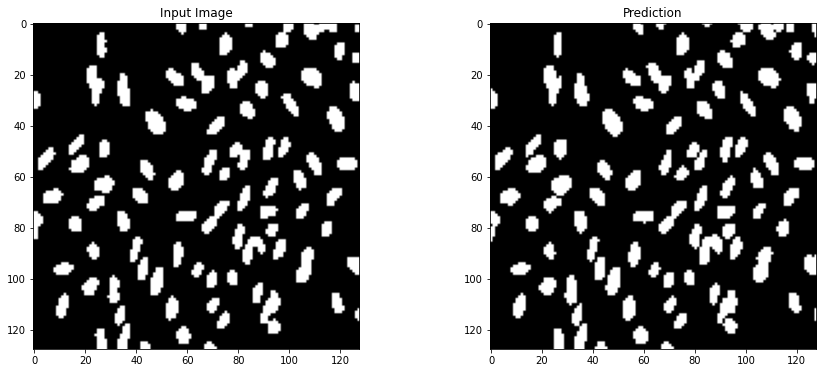

In [ ]:
for img_, mask_ in valid_loader:
    img = img_[1].to(device)
    img.unsqueeze_(0)
    mask_pred = model3(img.float())
    mask_pred = mask_pred.cpu()
    mask_pred = (mask_pred > 0.75)
    mask_true = mask_[1]

    img = TF.to_pil_image(mask_pred.float().squeeze(0))
    mask = TF.to_pil_image(mask_true)

    img = np.array(img)
    mask = np.array(mask)

    fig, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(15, 6))
    axis_1.imshow(img.astype(np.uint8), cmap='gray')
    axis_1.set_title('Input Image')
    axis_2.imshow(mask.astype(np.uint8), cmap='gray')
    axis_2.set_title('Prediction')
    plt.show()

    break

- OpenCV Data Augmentation 기법을 적용하여 진행되었을 때는 마지막 epoch에서 Train IoU가 0.74, Validation IoU가 0.73 정도입니다.
- 이번에는 대부분의 결과와 시각화가 비슷하게 나왔습니다.


### 4) 결론
<img src ="https://drive.google.com/uc?export=view&id=1G2Hifaln908zmZ3i0WqGBkyatltB7nKj">

- IoU값을 비교해서 표로 만들어본 결과입니다.
- 기본 U-Net 성능에 비해 ResU-Net이 더 좋은 성능을 도출한 것을 확인할 수 있습니다!
- ResU-Net에서는 Augmentation 기법을 쓰지 않은 데이터가 가장 좋은 결과를 얻었습니다!
- OpenCV에서는 U-Net과 다르게 비슷한 결과를 얻은 것을 확인할 수 있었습니다.

### [마무리]
- ResU-Net에 대하여 공부하고 전처리 기법들을 적용시켜보았습니다.
- 다음은 똑같은 방법을 RPA_ResU-Net에 적용해 마지막 최종 결론까지 가져오겠습니다!
- U-Net은 시간이 얼마 안걸리는데 ResU-Net은 굉장히 오랜 시간이 걸렸습니다. 따라서 RPA_ResU-Net은 거의 5시간이 넘어도 25epoch을 따라잡을 수 없기에 ! 5epoch를 기준으로 하였습니다!
- **다음 게시글에서 만나요 ~**

# 감사합니다 :)